In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import matplotlib as plt
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torch.nn import *
import cv2
# import wandb
# from wandb.fastai import WandbCallback

In [3]:
class CE_DiceLoss(nn.Module):
    def __init__(self):
        super(CE_DiceLoss, self).__init__()

    def forward(self, inp, target):
        inp = torch.sigmoid(inp)
        target = target.type(torch.FloatTensor).cuda()
        CE_val = nn.BCELoss(inp, target)
        dice_val = self.dice_loss(inp, target)
        
        return (CE_val + dice_val)/2
        
    def dice_loss(self, inp, target):
        smooth = 1.
        loss = 0.
        for c in range(n_classes):
            iflat = inp[:, c ].view(-1)
            tflat = target[:, c].view(-1)
            intersection = (iflat * tflat).sum()

            w = class_weights[c]
            loss += w * (1 - ((2. * intersection + smooth)/(iflat.sum() + tflat.sum() + smooth)))
        return loss

In [4]:
path = Path("/home/ubuntu/Kharbanda/Buildings")
path_img = path/'Images'
path_mask = path/'Masks'

In [5]:
all_img = get_image_files(path_img)
fname = [x for x in all_img if str(x.stem[:5]) == "3band"] 
fname[:5]

[PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img5750.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img6415.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img600.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img6329.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img435.tif')]

In [6]:
get_y_fn = lambda x: path_mask/f'{Path(x).name}'

In [7]:
# ref_img = [x for x in fname if list(open_mask(get_y_fn(x)).data.unique()) == list(tensor([0,1]))]

# string = 'Images/'
# data = [string + x.name for x in ref_img]

# v1_df = pd.DataFrame(data, columns = ['Images'])
# v1_df.to_csv("Rio_C_buildings.csv")

In [8]:
rio_df = pd.read_csv(path/'Rio_C_buildings.csv')
rio_df = rio_df.drop(columns = 'Unnamed: 0')
rio_df.head()

,Images
0,Images/3band_AOI_1_RIO_img5750.tif
1,Images/3band_AOI_1_RIO_img435.tif
2,Images/3band_AOI_1_RIO_img3455.tif
3,Images/3band_AOI_1_RIO_img5529.tif
4,Images/3band_AOI_1_RIO_img4895.tif


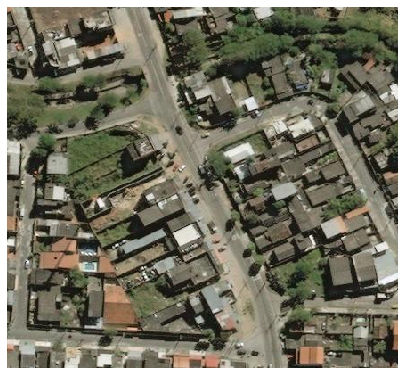

In [9]:
img = open_image(fname[9])
img.show(figsize=(7,7))

In [10]:
def save_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.save(f'{City}_{Freezed}_{Size}_{Iter}')
    
def load_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.load(f'{City}_{Freezed}_{Size}_{Iter}')

In [11]:
codes = [0,'building']
random.seed(42)
src = (SegmentationItemList.from_df(rio_df, path).
      split_by_rand_pct(.1).
      label_from_func(get_y_fn, classes=codes))

In [12]:
bs = 64
size = 224
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15, max_zoom=1.2, max_lighting = 0.5),
                      size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

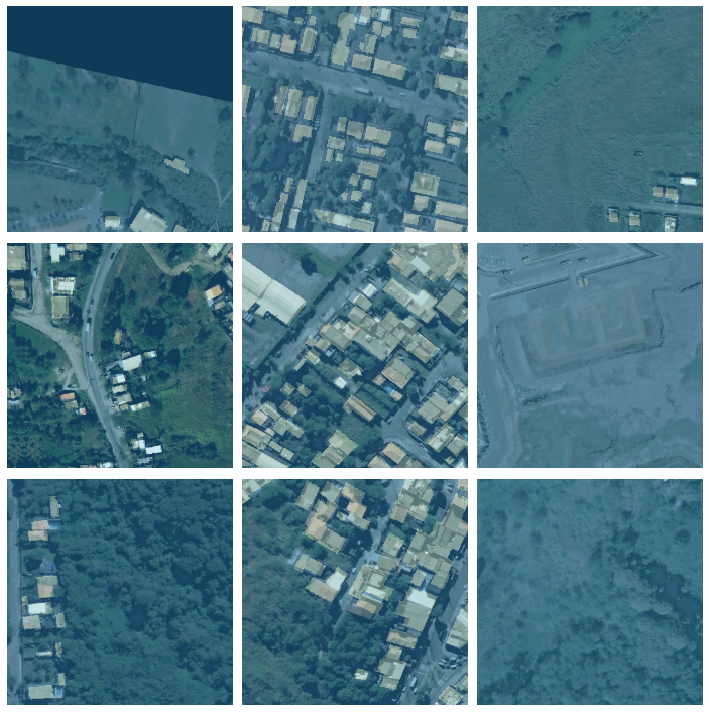

In [14]:
data.show_batch(3, figsize=(10,10))

In [15]:
# wd = 1e-3
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, 
                     norm_type=NormType.Weight, self_attention=True).to_fp16()
learn.loss = CE_DiceLoss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


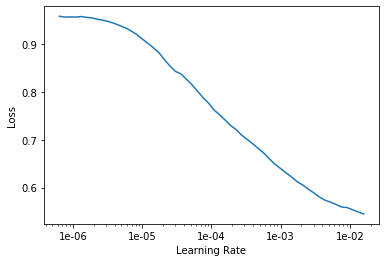

In [16]:
learn.lr_find()
learn.recorder.plot() 

In [17]:
learn.fit_one_cycle(5, slice(1e-3))

epoch,train_loss,valid_loss,dice,time
0,0.325489,0.276372,0.361071,00:38
1,0.246151,0.229778,0.523483,00:37
2,0.211382,0.237595,0.546169,00:37
3,0.195427,0.213523,0.548763,00:36
4,0.188514,0.212833,0.547421,00:37


In [18]:
save_model(learn, 'Rio_C', 'F', 'smol', 1)

# Start Recording

In [13]:
import wandb
from wandb.fastai import WandbCallback

In [20]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                    self_attention=True, callback_fns=partial(WandbCallback, input_type='images')).to_fp16()
learn.loss = CE_DiceLoss

In [21]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Rio.ipynb"

In [22]:
wandb.init(project="spacenet_buildings", name = 'Rio_smol_C')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/lktk6p3p

In [23]:
load_model(learn, 'Rio_C', 'F', 'smol', 1)

In [24]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.6)

epoch,train_loss,valid_loss,dice,time
0,0.182844,0.212823,0.552689,00:37
1,0.181720,0.210059,0.547366,00:37
2,0.182407,0.207654,0.556576,00:37
3,0.181297,0.209699,0.563421,00:37
4,0.183348,0.208466,0.561827,00:37
5,0.180595,0.207078,0.543364,00:37
6,0.177537,0.201842,0.564067,00:37
7,0.175120,0.204945,0.574914,00:37
8,0.173014,0.199342,0.571630,00:37
9,0.169922,0.198983,0.568697,00:37


Better model found at epoch 0 with valid_loss value: 0.21282267570495605.
Better model found at epoch 1 with valid_loss value: 0.21005892753601074.
Better model found at epoch 2 with valid_loss value: 0.2076541781425476.
Better model found at epoch 5 with valid_loss value: 0.20707842707633972.
Better model found at epoch 6 with valid_loss value: 0.20184186100959778.
Better model found at epoch 9 with valid_loss value: 0.19898344576358795.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_153351-lktk6p3p/bestmodel.pth


In [25]:
save_model(learn, 'Rio_C', 'F', 'smol', 2)

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.170368,0.198791,0.570066,00:38
1,0.169011,0.198572,0.569237,00:38
2,0.169824,0.198125,0.568720,00:38
3,0.169981,0.198187,0.566240,00:38
4,0.168141,0.197994,0.572416,00:38
5,0.168394,0.200114,0.584506,00:38
6,0.168808,0.196525,0.563725,00:38
7,0.168519,0.196274,0.570083,00:37
8,0.165960,0.197120,0.566294,00:38
9,0.165736,0.195888,0.574068,00:37


Better model found at epoch 0 with valid_loss value: 0.1987905502319336.
Better model found at epoch 1 with valid_loss value: 0.19857165217399597.
Better model found at epoch 2 with valid_loss value: 0.1981247067451477.
Better model found at epoch 4 with valid_loss value: 0.1979941427707672.
Better model found at epoch 6 with valid_loss value: 0.1965252161026001.
Better model found at epoch 7 with valid_loss value: 0.19627360999584198.
Better model found at epoch 9 with valid_loss value: 0.19588813185691833.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_153351-lktk6p3p/bestmodel.pth


In [28]:
save_model(learn, 'Rio_C', 'UF', 'smol', 1)

In [29]:
learn.fit_one_cycle(10, slice(1e-6, 1e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.165737,0.195873,0.574381,00:38
1,0.165659,0.195764,0.575111,00:38
2,0.165210,0.195753,0.576314,00:38
3,0.165212,0.195702,0.575696,00:37
4,0.165743,0.195766,0.571846,00:37
5,0.166014,0.195659,0.572230,00:37
6,0.164464,0.195521,0.571652,00:38
7,0.165519,0.195497,0.574750,00:37
8,0.164851,0.195393,0.576174,00:38
9,0.164492,0.195509,0.576170,00:38


Better model found at epoch 0 with valid_loss value: 0.19587309658527374.
Better model found at epoch 1 with valid_loss value: 0.19576437771320343.
Better model found at epoch 2 with valid_loss value: 0.19575311243534088.
Better model found at epoch 3 with valid_loss value: 0.1957021951675415.
Better model found at epoch 5 with valid_loss value: 0.19565948843955994.
Better model found at epoch 6 with valid_loss value: 0.19552098214626312.
Better model found at epoch 7 with valid_loss value: 0.19549725949764252.
Better model found at epoch 8 with valid_loss value: 0.1953926384449005.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_153351-lktk6p3p/bestmodel.pth


In [30]:
save_model(learn, 'Rio_C', 'UF', 'smaol', 2)

# GO BIG

In [14]:
bs = 16
size = 400
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15, max_zoom=1.2, max_lighting = 0.5),
                      size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

In [15]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                    self_attention=True, callback_fns=partial(WandbCallback, input_type='images')).to_fp16()
learn.loss = CE_DiceLoss

In [16]:
load_model(learn, 'Rio_C', 'UF', 'smaol', 2)

In [17]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Rio.ipynb"

In [18]:
wandb.init(project="spacenet_buildings", name = 'Rio_Big_SA_C')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/1h861g0d

In [19]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.177279,0.164664,0.571311,02:18
1,0.174577,0.164401,0.568136,02:02
2,0.173968,0.165994,0.568559,02:02
3,0.172491,0.165797,0.576498,02:02
4,0.172460,0.163853,0.585461,02:03
5,0.172219,0.165717,0.553724,02:02
6,0.175519,0.164733,0.584950,02:03
7,0.164248,0.163605,0.588915,02:03
8,0.163098,0.160805,0.565191,02:02
9,0.164563,0.157863,0.587900,02:02


Better model found at epoch 0 with valid_loss value: 0.16466426849365234.
Better model found at epoch 1 with valid_loss value: 0.1644010692834854.
Better model found at epoch 4 with valid_loss value: 0.16385304927825928.
Better model found at epoch 7 with valid_loss value: 0.16360485553741455.
Better model found at epoch 8 with valid_loss value: 0.1608053296804428.
Better model found at epoch 9 with valid_loss value: 0.15786314010620117.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_165726-1h861g0d/bestmodel.pth


In [20]:
save_model(learn, 'Rio_C', 'F', 'big', 1)

In [21]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.161367,0.157886,0.586979,02:02
1,0.160313,0.157914,0.592422,02:02
2,0.159573,0.157399,0.587020,02:02
3,0.156344,0.158073,0.594497,02:02
4,0.157978,0.158903,0.584804,02:02
5,0.164462,0.159428,0.580464,02:03
6,0.160735,0.158512,0.582773,02:03
7,0.161020,0.158338,0.584298,02:02
8,0.153986,0.157300,0.589330,02:02
9,0.157598,0.156740,0.593385,02:03


Better model found at epoch 0 with valid_loss value: 0.15788564085960388.
Better model found at epoch 2 with valid_loss value: 0.15739908814430237.
Better model found at epoch 8 with valid_loss value: 0.15729981660842896.
Better model found at epoch 9 with valid_loss value: 0.1567397564649582.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_165726-1h861g0d/bestmodel.pth


In [23]:
save_model(learn, 'Rio_C', 'UF', 'big', 1)

In [24]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.156608,0.156690,0.591188,02:03
1,0.154541,0.156416,0.592696,02:03
2,0.158818,0.156790,0.598149,02:02
3,0.161086,0.156382,0.597548,02:02
4,0.156607,0.160003,0.595442,02:02
5,0.162881,0.156037,0.595302,02:02
6,0.152050,0.157133,0.586371,02:02
7,0.153635,0.156293,0.592287,02:03
8,0.151648,0.155851,0.595623,02:02
9,0.153448,0.155609,0.594204,02:02


Better model found at epoch 0 with valid_loss value: 0.15669012069702148.
Better model found at epoch 1 with valid_loss value: 0.15641555190086365.
Better model found at epoch 3 with valid_loss value: 0.1563817411661148.
Better model found at epoch 5 with valid_loss value: 0.15603668987751007.
Better model found at epoch 8 with valid_loss value: 0.15585078299045563.
Better model found at epoch 9 with valid_loss value: 0.15560884773731232.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_165726-1h861g0d/bestmodel.pth


In [25]:
save_model(learn, 'Rio_C', 'UF', 'big', 2)

In [26]:
learn.fit_one_cycle(10, slice(5e-7, 5e-6), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.154465,0.155593,0.594142,02:04
1,0.154037,0.155599,0.594345,02:02
2,0.153145,0.155530,0.594556,02:02
3,0.155322,0.155467,0.594964,02:03
4,0.153313,0.155484,0.593086,02:03
5,0.150377,0.155520,0.591784,02:03
6,0.155262,0.155594,0.595331,02:03
7,0.156713,0.155702,0.593735,02:03
8,0.153030,0.155394,0.593522,02:02
9,0.153209,0.155353,0.593082,02:02


Better model found at epoch 0 with valid_loss value: 0.15559256076812744.
Better model found at epoch 2 with valid_loss value: 0.15553005039691925.
Better model found at epoch 3 with valid_loss value: 0.15546730160713196.
Better model found at epoch 8 with valid_loss value: 0.15539366006851196.
Better model found at epoch 9 with valid_loss value: 0.15535348653793335.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_165726-1h861g0d/bestmodel.pth


In [27]:
save_model(learn, 'Rio_C', 'UF', 'big', 3)